In [9]:
# Import packages
import os
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, HTML
import statsmodels.api as sm
#os.listdir()

Estimating Residential Electricity Consumption

Predicting how much electricity a home will use is important to various entities, such as prospective homebuyers, landlords, and developers. The Energy Information Administration (EIA) conducts a survey of residential energy usage (known as 'RECS') which is a feature rich dataset describing building and homeowner properties.

The dataset consists of 5,686 observations and 758 features.

In [2]:
# Data Collection
# Data files and codebook from: https://www.eia.gov/consumption/residential/data/2015/index.php?view=microdata

# Load and Preview DataFrame
df = pd.read_csv('recs2015.csv')
df = df.set_index(['DOEID'])
print(df.shape)
df.head()

(5686, 758)


,REGIONC,DIVISION,METROMICRO,UATYP10,TYPEHUQ,ZTYPEHUQ,CELLAR,ZCELLAR,BASEFIN,ZBASEFIN,...,ZELAMOUNT,NGXBTU,PERIODNG,ZNGAMOUNT,FOXBTU,PERIODFO,ZFOAMOUNT,LPXBTU,PERIODLP,ZLPAMOUNT
DOEID,,,,,,,,,,,,,,,,,,,,,
10001,4,10,METRO,U,2,0,0,0,-2,-2,...,0,103.32,1,0,137.45,-2,-2,91.33,-2,-2
10002,3,7,NONE,R,2,0,0,0,-2,-2,...,1,NaN,-2,-2,137.45,-2,-2,91.33,-2,-2
10003,3,6,METRO,U,2,0,1,0,1,0,...,0,100.14,1,0,137.45,-2,-2,91.33,-2,-2
10004,2,4,MICRO,C,2,0,1,0,1,0,...,0,NaN,-2,-2,137.45,-2,-2,91.33,2,0
10005,1,2,METRO,U,2,0,1,0,0,0,...,0,102.83,1,0,137.45,-2,-2,91.33,-2,-2


### Exploratory Data Analysis

Because the dataset has so many features, it is difficult to look at as a whole. I start by creating some boxplots for what I expect are important variables. The plots below show that number of bedrooms is very significant. However, the decade in which the home was built (feature 'YEARMADERANGE') does not appear as important, despite efforts at increasing home efficiency in more recent years. The only geographic region that stands out as using significantly different electricity consumption from other regions is Region 3.

<AxesSubplot:xlabel='BEDROOMS', ylabel='KWH'>

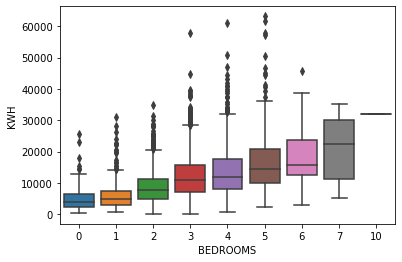

In [3]:
sns.boxplot(x=df['BEDROOMS'],y=df['KWH'])

<AxesSubplot:xlabel='YEARMADERANGE', ylabel='KWH'>

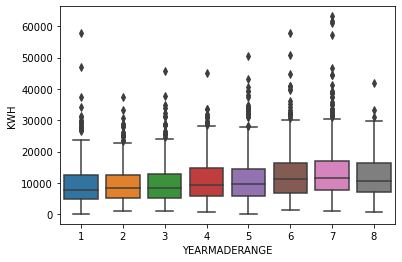

In [4]:
sns.boxplot(x=df['YEARMADERANGE'],y=df['KWH'])

<AxesSubplot:xlabel='REGIONC', ylabel='KWH'>

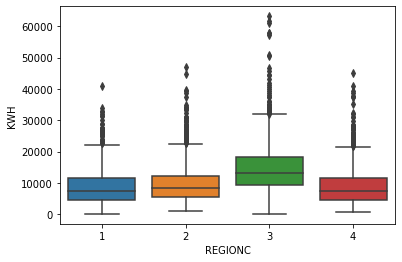

In [5]:
sns.boxplot(x=df['REGIONC'],y=df['KWH'])

Another EDA technique I explore is a dendogram. The model will ultimately need to reduce the 758 features to a much more manageable number, and the dendogram may help show which building materials are similar and can possibly be clustered into a smaller number of features. The features with the shortest leaves are most similar and those with the longest are most dissimilar, making them important.

ROOFTYPE_5, the most important building material, is a shingles roof.

Materials with the most similar data are slate roof (ROOFTYPE_4) and type "Other" wall (WALLTYPE_9), meaning it is none of the other listed walltypes such as brick, wood, stone, or concrete block.

The dendogram can show interesting relationships, but ultimately there are too many variables to analyze manually and it needs a machine learning method for feature engineering/selection.


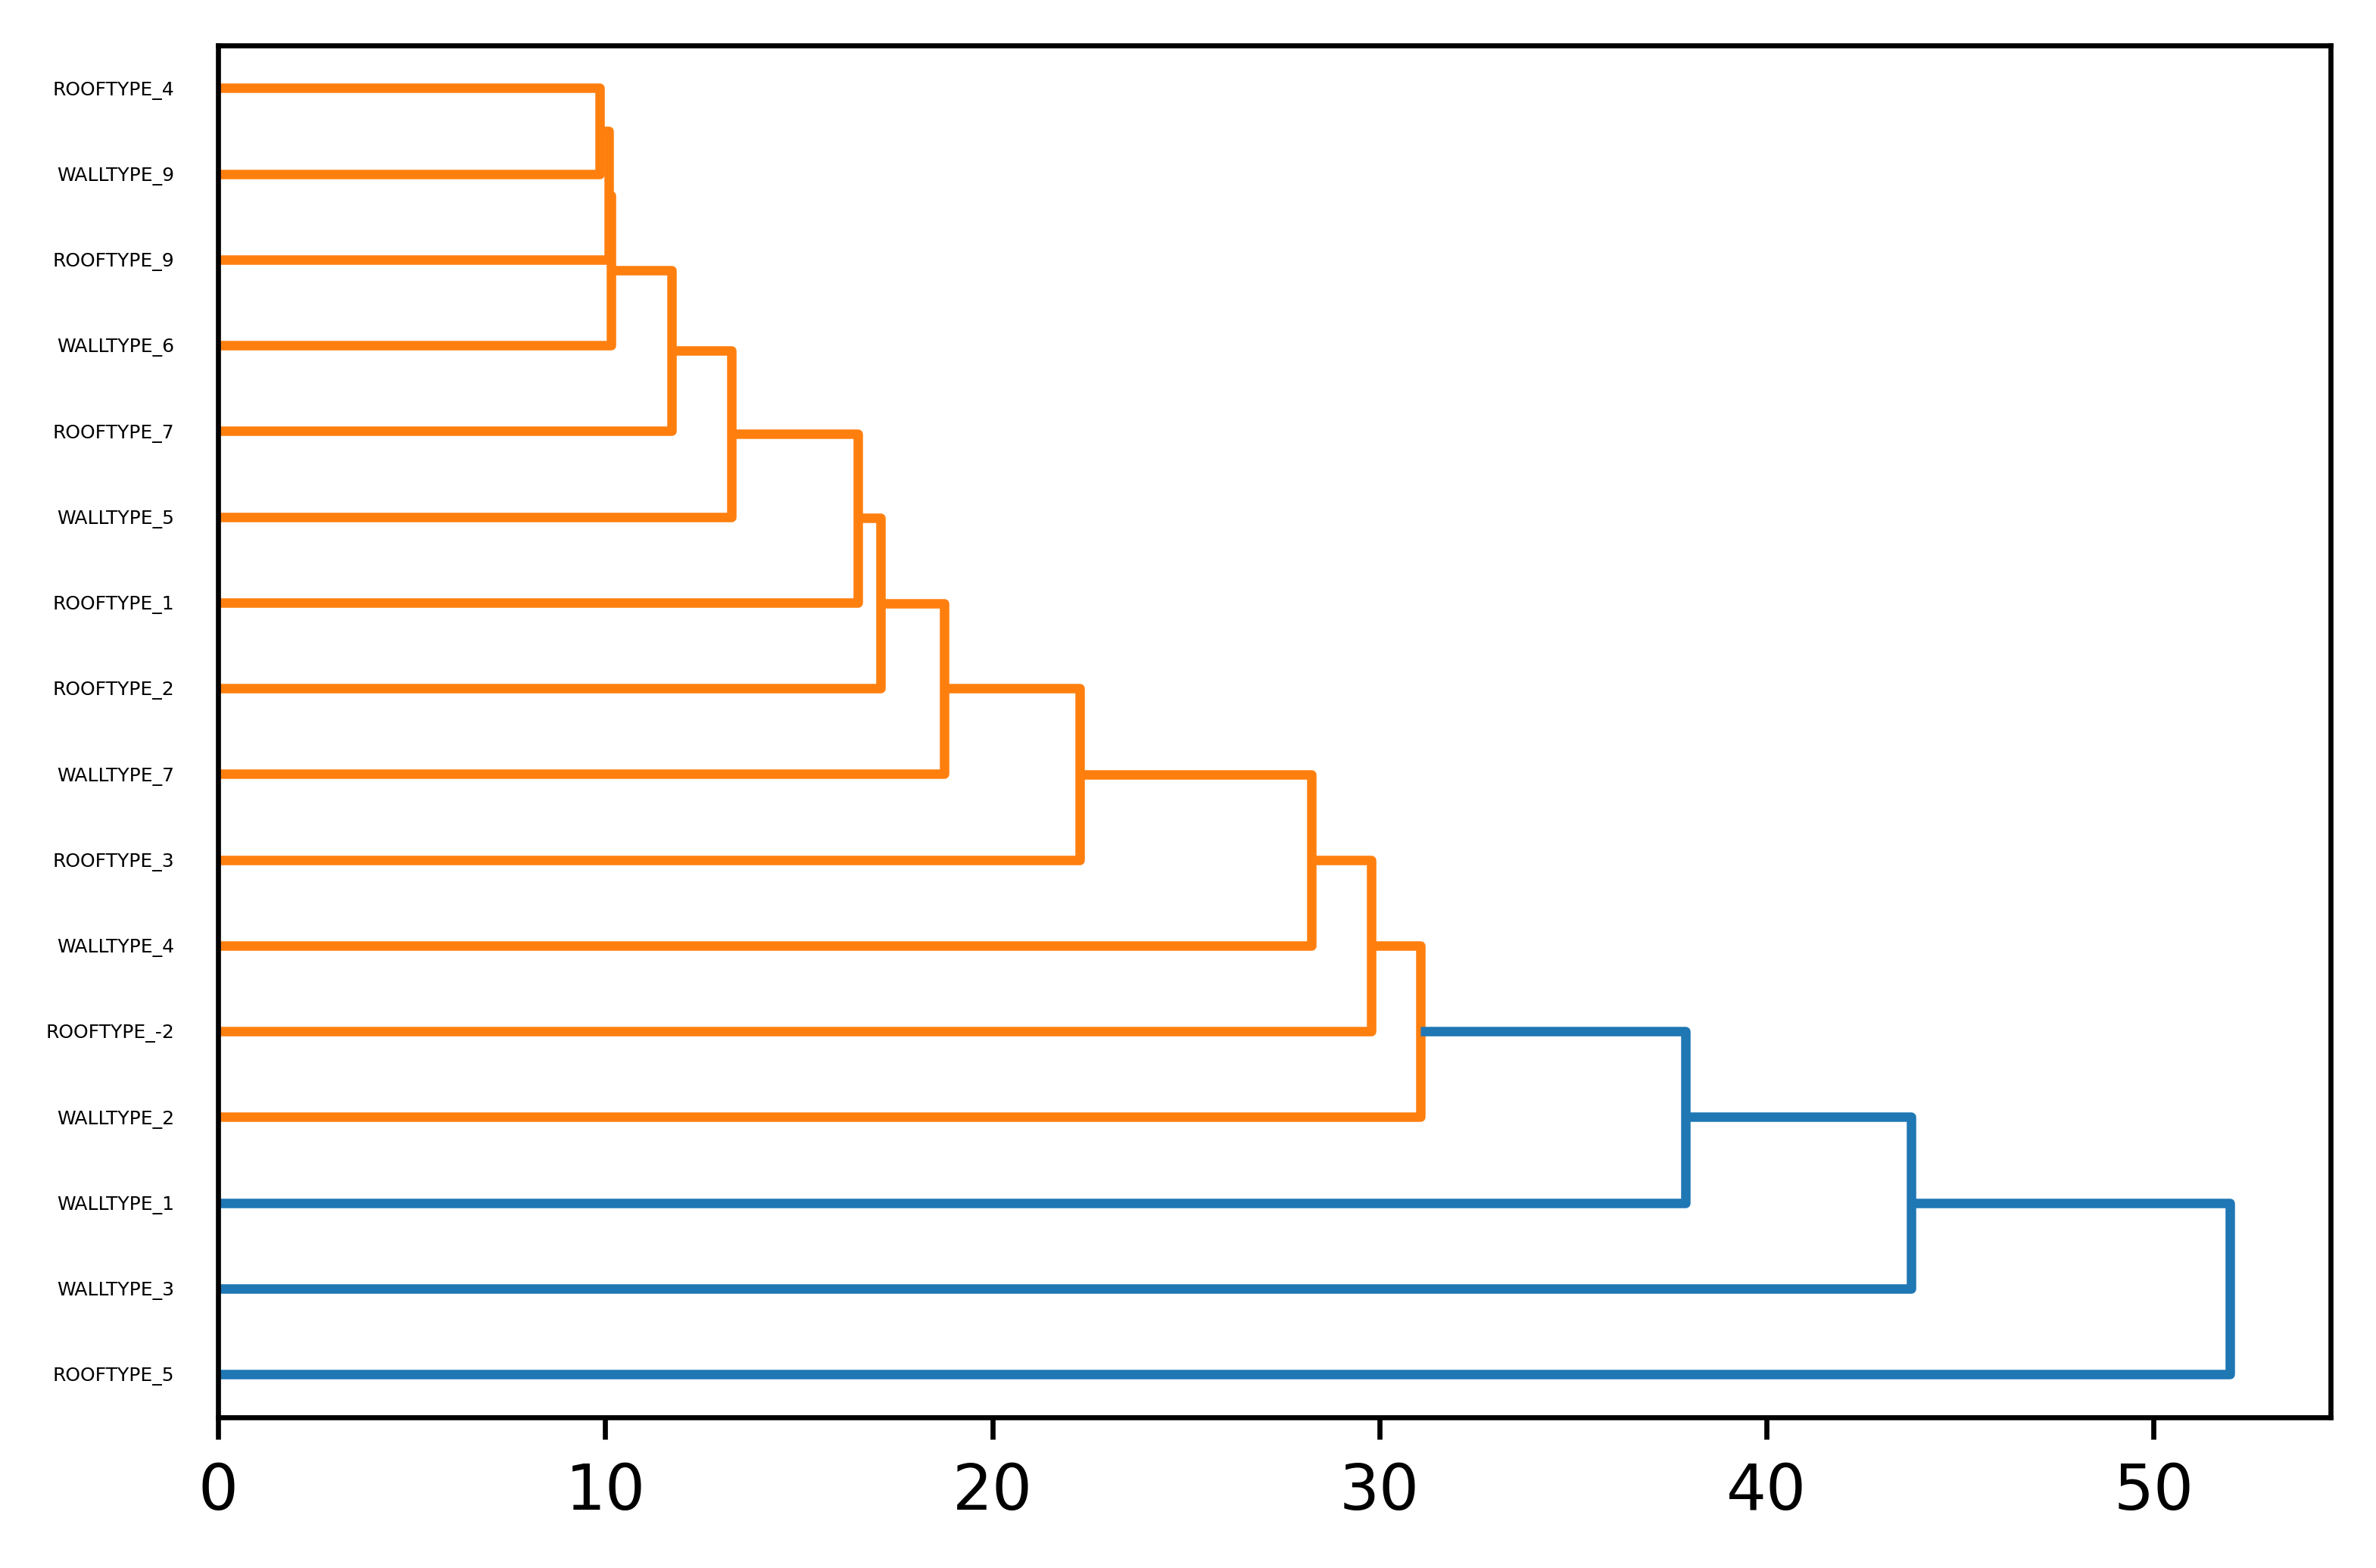

<Figure size 9000x6000 with 0 Axes>

,WALLTYPE_1,WALLTYPE_2,WALLTYPE_3,WALLTYPE_4,WALLTYPE_5,WALLTYPE_6,WALLTYPE_7,WALLTYPE_9,ROOFTYPE_-2,ROOFTYPE_1,ROOFTYPE_2,ROOFTYPE_3,ROOFTYPE_4,ROOFTYPE_5,ROOFTYPE_7,ROOFTYPE_9
DOEID,,,,,,,,,,,,,,,,
10001,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0
10002,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
10003,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0
10004,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
10005,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [11]:
# Perform hierarchial clustering on building properties
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.preprocessing import normalize

X0 = pd.get_dummies(df[['WALLTYPE', 'ROOFTYPE']].astype(str))

mergings = linkage(X0.T, method='single')
dendrogram(mergings, labels=X0.columns, leaf_rotation=0, leaf_font_size=3, orientation='right')
plt.figure(figsize=(15,10))
plt.show()
plt.rcParams['figure.dpi'] = 600
X0.head()

### Data Cleaning

There are many features that have no impact or unlikely impact on electricity consumption, such as columns for imputation flags or costs of other utilities. All of the feature descriptions and variable codes are described in a separate Excel workbook from EIA, so I went through those manually and imported the below lists of features to eliminate.

#### -->Eliminate Extraneous Features

In [7]:
# Read in lists of non-predictive features
impute0 = pd.read_excel('Data Cleaning/imputation_flags.xlsx')['Variable']
conversion0 = pd.read_excel('Data Cleaning/conversion_factors.xlsx')['Variable']
other_utilities0 = pd.read_excel('Data Cleaning/other_utilities.xlsx')['Variable']
estimators0 = pd.read_excel('Data Cleaning/statistical_estimators.xlsx')['Variable']
utility_costs0 = pd.read_excel('Data Cleaning/utility_costs.xlsx')['Variable']
miscellaneous0 = pd.read_excel('Data Cleaning/miscellaneous_not_used.xlsx')['Variable']
redundant0 = pd.read_excel('Data Cleaning/redundant_vars.xlsx')['Variable']
detailed0 = pd.read_excel('Data Cleaning/detailed_audit.xlsx')['Variable']

In [8]:
# Read in lists of similar predictive features that may work better as clusters or principal components
tenant_behavior_c = pd.read_excel('Data Cleaning/tenant_behavior_cluster.xlsx')['Variable']
energy_star_c = pd.read_excel('Data Cleaning/energy_star_cluster.xlsx')['Variable']
energy_assistance_c = pd.read_excel('Data Cleaning/energy_assistance_cluster.xlsx')['Variable']

In [9]:
# Combine nonpredictive features into a single list
nonpredict = np.concatenate((impute0, conversion0, other_utilities0, estimators0, utility_costs0, miscellaneous0, redundant0, detailed0), axis=0)

In [10]:
# Combine clusters into list to be temporarily dropped
clustervars = np.concatenate((tenant_behavior_c, energy_star_c, energy_assistance_c), axis=0)

In [11]:
# Drop nonpredictive features
df = df.drop(nonpredict, axis=1)
df = df.drop(clustervars, axis=1)

After removing, I check for any other missing or unusable values.

#### -->Inspect Resulting Dataframe

In [12]:
# Count missing values: {'Not applicable': -2, 'Don't Know': -9, 'Refuse': -8}

# Create mask for each type of missing value
na_mask = df.apply(lambda x: x==-2)
dk_mask = df.apply(lambda x: x==-9)
refuse_mask = df.apply(lambda x: x==-8)

In [13]:
# Count number of instances where mask is True, then filter out columns with no missing values
na = df[na_mask].count()[df[na_mask].count() > 0]
dk = df[dk_mask].count()[df[dk_mask].count() > 0]
refuse = df[refuse_mask].count()[df[refuse_mask].count() > 0]

print(str(len(na.index)) + ' columns containing \"Not applicable\" values.')
print(str(len(dk.index)) + ' columns containing \"Dont know\" values.')
print(str(len(refuse.index)) + ' columns containing \"Refuse\" values.')

48 columns containing "Not applicable" values.
4 columns containing "Dont know" values.
2 columns containing "Refuse" values.


#### -->Replace Negative Variables

In [14]:
# Replace negative values for binary variables (i.e. where negatives are "not applicable")
# Read in binary variables
binaryvars = pd.read_excel('Data Cleaning/binary_vars.xlsx')['Variable']

# Filter out negative values ("Not applicable" means approximately the same as "no" or "does not have")
df[binaryvars] = df[binaryvars].apply(lambda x: (x>0)*x)

#### -->Make Categorical Variables Dummy Variables

In [15]:
# Create dummy variables for columns with missing answers, making the missing values the base case.

# Read in list of categorical variables
cat_vars = pd.read_excel('Data Cleaning/categorical_vars.xlsx')['Variable']

In [16]:
df = pd.get_dummies(df.astype(str), columns=cat_vars, drop_first=True, prefix=cat_vars).astype('float64')

In [17]:
# Check missing values
print(df.isna().sum().max())

# Inspect DataFrame
df.shape

0


(5686, 227)

### Feature Selection

In [18]:
# Feature Selection

from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split

In [19]:
# Split Data
X = df.drop('KWH', axis=1)
names = df.drop('KWH', axis=1).columns
y = df['KWH']

Finally, inspect which features result using Lasso regression.

#### -->Lasso Regression

In [20]:
# Lasso: Select Features

lasso = Lasso(alpha=1, max_iter=1000, normalize=True)
lasso_coef = lasso.fit(X,y).coef_
coef = pd.DataFrame(lasso_coef, names)
coef_names = coef[coef[0]>0].index
print(coef_names)
len(coef_names)

Index(['ATTIC', 'BEDROOMS', 'NCOMBATH', 'NHAFBATH', 'TOTROOMS', 'HIGHCEIL',
       'WINDOWS', 'ADQINSUL', 'SWIMPOOL', 'POOL', 'RECBATH', 'BACKUP',
       'NUMFRIG', 'NUMFREEZ', 'OVEN', 'DISHWASH', 'DRYER', 'AIRCOND',
       'CENACHP', 'NUMBERAC', 'GARGCOOL', 'MORETHAN1H2O', 'NHSLDMEM',
       'NUMADULT', 'MONEYPY', 'ELWARM', 'ELCOOL', 'ELFOOD', 'TOTCSQFT',
       'TOTSQFT_EN', 'CDD30YR', 'DBT1', 'REGIONC_3', 'METROMICRO_MICRO',
       'UATYP10_R', 'TYPEHUQ_2', 'STORIES_10', 'WALLTYPE_6', 'ROOFTYPE_3',
       'ROOFTYPE_4', 'FUELPOOL_1', 'FUELPOOL_5', 'FUELTUB_2', 'FUELTUB_21',
       'FUELTUB_5', 'STOVEFUEL_2', 'DRYRFUEL_5', 'FUELHEAT_5',
       'EQUIPAUXTYPE_9', 'COOLTYPE_3', 'FUELH2O_5', 'WHEATSIZ_3', 'FUELH2O2_5',
       'IECC_CLIMATE_PUB_4A', 'IECC_CLIMATE_PUB_4C', 'SIZEOFGARAGE_3',
       'AGECENAC_42', 'WWACAGE_2', 'WWACAGE_41'],
      dtype='object')


59